In [ ]:
!pip install flwr-datasets

In [ ]:
!pip install flwr[simulation]

In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade cryptography==44.0.1

In [ ]:
# Standard libraries
import os
import time
import json
from collections import Counter, OrderedDict
from typing import Dict, List, Tuple

# Third-party libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Hugging Face datasets
from datasets import load_dataset, Dataset

# Flower
from flwr.client import NumPyClient, ClientApp
from flwr.common import NDArrays, Scalar, Context, Metrics, ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets.partitioner import Partitioner
from flwr_datasets.visualization import plot_label_distributions

# Kaggle (if used to pull data)
import kagglehub

In [301]:
root = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
print("Path to dataset files:", root)

Path to dataset files: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1


In [302]:
class ManualPartitioner(Partitioner):
    def __init__(self, partitions: Dict[int, list]):
        super().__init__()
        self.partitions = partitions  # Maps partition_id -> list of indices
        self._dataset: Dataset = None

    @property
    def num_partitions(self) -> int:
        return len(self.partitions)

    @property
    def dataset(self) -> Dataset:
        return self._dataset

    @dataset.setter
    def dataset(self, dataset: Dataset) -> None:
        if not isinstance(dataset, Dataset):
            raise TypeError("Only Hugging Face datasets.Dataset is supported.")
        self._dataset = dataset

    def load_partition(self, partition_id: int) -> Dataset:
        if self._dataset is None:
            raise ValueError("Dataset not assigned to the partitioner.")
        indices = self.partitions.get(partition_id)
        if indices is None:
            raise ValueError(f"No partition found for partition_id {partition_id}.")
        return self._dataset.select(indices)


In [337]:
class OneForTwoDataset(Dataset):
    def __init__(self, root1, root2, transform=None, input_size=64, use_cache=True):
        self.transform = transform
        self.input_size = input_size
        self.use_cache = use_cache
        self.cache = {}  # Dictionary for caching images

        # Load modality 1
        self.mod1_dataset = ImageFolder(root1)
        self.mod1_samples = self.mod1_dataset.samples  # List of (path, label)

        # Load modality 2
        self.mod2_dataset = ImageFolder(root2)
        self.mod2_samples = self.mod2_dataset.samples

        # Construct unified sample list with modality index
        self.id = 0
        self.samples = []
        for path, label in self.mod1_samples:
            self.samples.append((path, label, 0, self.id))  # 0 for modality 1

            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            self.cache[path] = image

            self.id += 1
        for path, label in self.mod2_samples:
            self.samples.append((path, label, 1, self.id))  # 1 for modality 2

            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            self.cache[path] = image

            self.id += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, modality_index, id = self.samples[idx]

        image = self.cache[path]

        return image, label, modality_index

In [324]:
dataset_path = root + '/Dataset'

modalities = [
    'Brain Tumor CT scan Images',
    'Brain Tumor MRI images'
]

modalities_path = [os.path.join(dataset_path, i) for i in modalities]
print(modalities_path)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

['/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor CT scan Images', '/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset/Brain Tumor MRI images']


In [338]:
main_ds = OneForTwoDataset(
    modalities_path[0],
    modalities_path[1],
    transform=transform,
    use_cache=True)

main_ds.__len__()

9618

In [339]:
modality_map = [modality for _, _, modality, _ in main_ds.samples]

In [340]:
modality_map_dict = {idx: modality for idx, (_, _, modality, _) in enumerate(main_ds.samples)}

partition_0 = [i for i, m in modality_map_dict.items() if m == 0]
partition_1 = [i for i, m in modality_map_dict.items() if m == 1]

manual_partitions = {
    0: partition_0,
    1: partition_1,
}

In [341]:
# Extract data from your OneForTwoDataset
data = []

for path, label, modality, id in main_ds.samples:
    data.append({
        "image": path,
        "label": label,
        "modality": modality,
        "id": id
    })

df = pd.DataFrame(data)
hf_dataset = Dataset.from_pandas(df)

In [342]:
partitioner = ManualPartitioner(partitions=manual_partitions)
partitioner.dataset = hf_dataset

# Load a specific partition
partition_0 = partitioner.load_partition(0)
print(partition_0)

Dataset({
    features: ['image', 'label', 'modality', 'id'],
    num_rows: 4618
})


/usr/local/lib/python3.11/dist-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


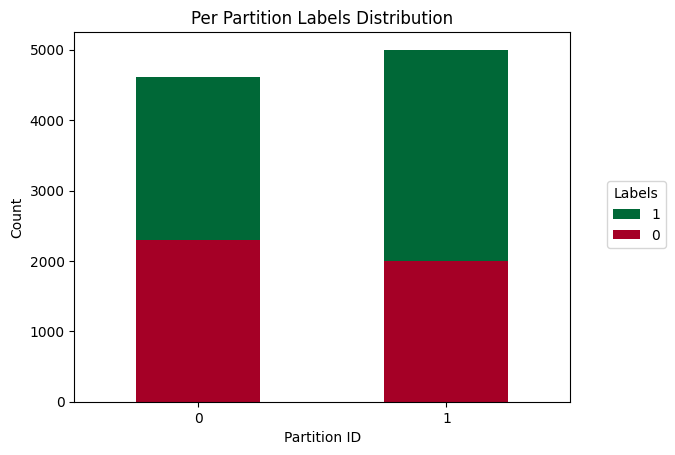

In [343]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

In [347]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, ds, transform=None, use_cache=False):
        self.dataset = hf_dataset
        self.cached = ds
        self.transform = transform or transforms.ToTensor()
        self.use_cache = use_cache
        self._cache = {} if use_cache else None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        image = self.cached[item['id']][0]
        result = (image, item["label"])

        return result

In [348]:
torch.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

def get_dataloaders(dataset, batch_size: int = 32):

    pytorch_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition_train_val = dataset.train_test_split(test_size=0.2, seed=42)

    train_dataset = HFDatasetWrapper(
        partition_train_val["train"], main_ds)
    val_dataset = HFDatasetWrapper(
        partition_train_val["test"], main_ds)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(
        train_dataset, batch_size=batch_size,
        shuffle=True, generator=g, num_workers=4)
    testloader = DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=4)

    return trainloader, testloader

In [350]:
partition_0 = partitioner.load_partition(1)

trainloader, testloader = get_dataloaders(partition_0)

for images, labels in tqdm(trainloader):
    continue

100%|██████████| 125/125 [00:00<00:00, 254.76it/s]


In [351]:
def train(net, id, trainloader, optimizer, device):

    #train_time = time.time()

    criterion = nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    running_loss = 0.0
    total = 0

    for images, labels in trainloader:
        #images, labels = batch["image"].to(device), batch["label"].to(device)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        running_loss += loss.item()

    #print(f"Loss: {running_loss/len(trainloader):.4f}")

    #train_time = time.time() - train_time
    #print(f"Training time: {train_time:.2f} seconds")

    return running_loss / len(trainloader)

def test(net, id, testloader, device):
    """Validate the network on the entire test set."""
    criterion = nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            #images, labels = batch["image"].to(device), batch["label"].to(device)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return loss / len(testloader), accuracy

In [352]:
class SimpleCNNBranch(nn.Module):
    def __init__(self):
        super(SimpleCNNBranch, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: 3xHxW
            nn.ReLU(),
            nn.MaxPool2d(2),  # H/2 x W/2

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # H/4 x W/4

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (64, 1, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # Flatten to (batch_size, 64)

class DualModalitySimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(DualModalitySimpleCNN, self).__init__()
        self.branch1 = SimpleCNNBranch()
        self.branch2 = SimpleCNNBranch()

        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x1, x2):
        f1 = self.branch1(x1)
        f2 = self.branch2(x2)
        fused = torch.cat((f1, f2), dim=1)
        return self.classifier(fused)

class SingleModalitySimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SingleModalitySimpleCNN, self).__init__()
        self.feature_extractor = SimpleCNNBranch()
        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

In [353]:
class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader, id) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id
        self.model = SingleModalitySimpleCNN(num_classes=2)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #print(f"Training on device: {self.device}")

    def fit(self, parameters, config):

        set_params(self.model, parameters)
        optim = torch.optim.Adam(self.model.parameters(), lr=0.001)
        train(self.model, self.id, self.trainloader, optim, self.device)

        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):

        set_params(self.model, parameters)
        loss, accuracy = test(self.model, self.id, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy, "loss": loss, 'id': self.id}


def set_params(model, parameters):

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

In [354]:
def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = partitioner.load_partition(partition_id)
    #partition_train_val = partition.train_test_split(test_size=0.2, seed=42)
    trainloader, testloader = get_dataloaders(partition, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader, id=partition_id).to_client()

client_app = ClientApp(client_fn=client_fn)

In [355]:
client_metrics = []

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    client_metrics.append(metrics)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [356]:
num_rounds = 100

def server_fn(context: Context):

    model = SingleModalitySimpleCNN(num_classes=2)
    ndarrays = get_params(model)

    global_model_init = ndarrays_to_parameters(ndarrays)

    strategy = FedAvg(
        fraction_fit=1.0,  # 10% clients sampled each round to do fit()
        fraction_evaluate=1.0,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    config = ServerConfig(num_rounds=num_rounds)

    return ServerAppComponents(strategy=strategy, config=config)


server_app = ServerApp(server_fn=server_fn)

In [357]:
start_time = time.time()

backend_config = {
    "client_resources": {
        "num_gpus": 1.0,
        "num_cpus": 8.0},
    "äctor": {
        "actor_reuse": False
    }
}

run_simulation(
    client_app=client_app,
    server_app=server_app,
    num_supernodes=2,
    backend_config=backend_config
)

end_time = time.time()
total_time = end_time - start_time
print(f"Total simulation time: {total_time:.2f} seconds")

INFO :      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(pid=141070) 2025-05-20 11:54:08.655481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=141070) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=141070) E0000 00:00:1747742048.675944  141070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=141070) E0000 00:00:1747742048.682079  141070 cuda_blas.cc:1418] Unable to register cuBLAS fac

Total simulation time: 1473.76 seconds


In [358]:
client_accs = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store accuracies for each client
client_losses = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store losses for each client

# Loop through each round of experiment (outer list)
for round_data in client_metrics:
    # Loop through each client (inner list)
    for client_idx, (_, metrics) in enumerate(round_data):
        # Append the accuracy and loss for the current client in this round
        client_accs[metrics['id']].append(metrics['accuracy'])
        client_losses[metrics['id']].append(metrics['loss'])

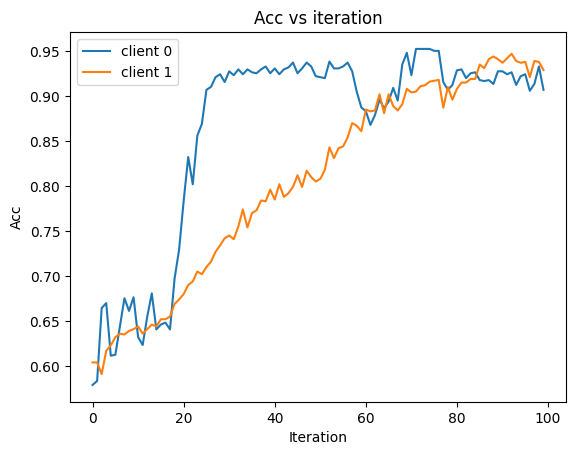

In [359]:
for i, client in enumerate(client_accs):
    plt.plot(client, label='client ' + str(i))
plt.title("Acc vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [360]:
to_save = {
    'accuracy': client_accs,
    'loss': client_losses}

with open('100_all_in_one_1.json', 'w') as f:
    json.dump(to_save, f)